In [1]:
import geopandas as gpd
vv_path = '/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vv-20250315t173950-20250315t174015-058318-07359a-001.tiff'
vh_path = '/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vh-20250315t173950-20250315t174015-058318-07359a-002.tiff'
roi_path = '/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/Rapaki Misc Data/RV_TARGET_ROI_2.shx'
roi = gpd.read_file(roi_path)


create a mosaic of all the tiles


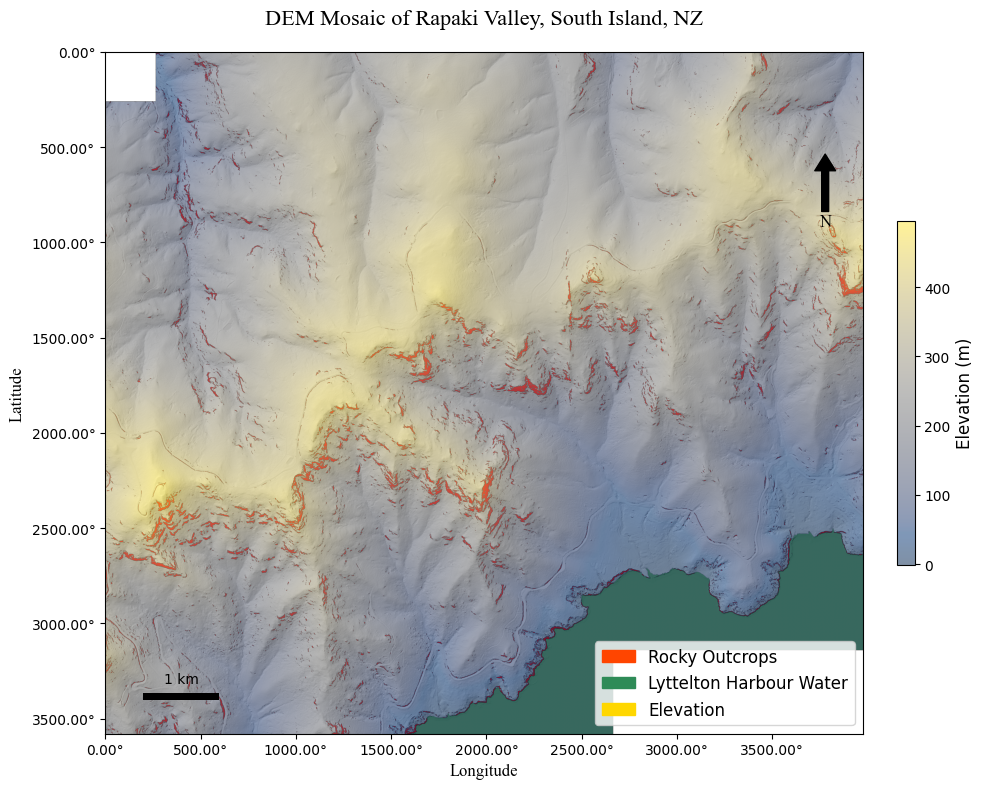

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, generic_filter, binary_dilation, binary_erosion
import rasterio
from rasterio.plot import show
from matplotlib.colors import Normalize
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from matplotlib import ticker
import matplotlib.font_manager as fm

# Step 1: Load your DEM file
with rasterio.open('/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL ANALYSIS/mosaic_dem.tif') as src:
    dem_array = src.read(1)  # Read the first band (assuming DEM is single-band)

    

    # Handle NoData values by masking them
    if src.nodata is not None:
        dem_array = np.ma.masked_equal(dem_array, src.nodata)

# Step 2: Compute the slope (gradient) of the DEM
gradient_x = sobel(dem_array, axis=0)  # gradient in x direction
gradient_y = sobel(dem_array, axis=1)  # gradient in y direction

# Step 3: Calculate the slope magnitude
slope = np.hypot(gradient_x, gradient_y)

# Step 4: Compute the aspect (direction of steepest slope)
aspect = np.arctan2(gradient_y, gradient_x)

# Step 5: Define thresholds for classification
road_threshold = 0.2  # Roads have slope less than 0.5
rocky_outcrop_lower_threshold = 8.0  # Rocky outcrops have slope closer to 90 degrees (steep slopes)
rocky_outcrop_upper_threshold = 90.0  # Adjusted to indicate steep slopes (close to vertical cliffs)
elevation_threshold = 2.0  # Adjust elevation threshold for flat terrain

# Step 6: Create a mask for roads (flat areas with slope less than 0.5)
roads = slope < road_threshold

# Step 7: Create a mask for rocky outcrops (areas with very steep slopes between 5 and 90 degrees)
rocky_outcrops = (slope >= rocky_outcrop_lower_threshold) & (slope <= rocky_outcrop_upper_threshold)

# Step 8: Define a water threshold (low elevation means likely water bodies)
water_threshold = 5.0  # Adjust this based on your DEM (e.g., areas below 5 meters elevation are water bodies)
water_areas = dem_array < water_threshold

# Step 9: Apply texture analysis to enhance road detection
def local_std(arr):
    return np.std(arr)

# Compute the local standard deviation to capture smooth areas (likely roads)
std_deviation = generic_filter(dem_array, local_std, size=3)  # size determines neighborhood size

# Mask roads based on texture (roads should have low standard deviation)
road_texture = std_deviation < 1.0  # Adjust threshold for smooth terrain

# Combine the slope and texture criteria for roads
final_roads = roads & road_texture

# Step 10: Apply morphological operations to clean the road mask
expanded_roads = binary_dilation(final_roads, structure=np.ones((3, 3)))  # Increase connectivity
final_roads_cleaned = binary_erosion(expanded_roads, structure=np.ones((3, 3)))  # Remove isolated regions

# Step 11: Apply an elevation difference filter to refine roads
elevation_difference_x = np.abs(np.diff(dem_array, axis=0))  # Difference along rows (axis 0)
elevation_difference_y = np.abs(np.diff(dem_array, axis=1))  # Difference along columns (axis 1)

# Pad the differences to match the shape of the original DEM array
elevation_difference_x_padded = np.pad(elevation_difference_x, ((0, 1), (0, 0)), mode='edge')  # Pad bottom row
elevation_difference_y_padded = np.pad(elevation_difference_y, ((0, 0), (0, 1)), mode='edge')  # Pad right column

# Combine the x and y differences
elevation_difference = elevation_difference_x_padded + elevation_difference_y_padded

# Define a threshold for elevation difference to help detect roads (adjust based on your data)
elevation_threshold = 0.01
elevation_filter = elevation_difference < elevation_threshold

# Mask roads further using elevation difference
final_roads_cleaned = final_roads_cleaned & elevation_filter

# Step 12: Plot the DEM with rocky outcrop and water areas highlighted
fig, ax = plt.subplots(figsize=(10, 8))

# Create hillshade effect for DEM
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem_array, vert_exag=1, dx=1, dy=1)

# Display hillshade on top of the DEM
ax.imshow(hillshade, cmap="gray", alpha=0.7)

# Highlight water areas by overlaying a transparent mask
water_overlay = np.ma.masked_where(~water_areas, water_areas)
ax.imshow(water_overlay, cmap="ocean", alpha=0.5)

# Highlight rocky outcrop areas by overlaying a transparent mask
rocky_overlay = np.ma.masked_where(~rocky_outcrops, rocky_outcrops)
ax.imshow(rocky_overlay, cmap="autumn", alpha=1.0)

# Add colorbar for elevation
elev_overlay = ax.imshow(dem_array, cmap=plt.cm.cividis, alpha=0.5)
cbar = plt.colorbar(elev_overlay, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Elevation (m)", fontsize=12)

# Add title and labels with Times New Roman
ax.set_title("DEM Mosaic of Rapaki Valley, South Island, NZ", fontsize=16, fontname="Times New Roman", pad=20)
ax.set_xlabel("Longitude", fontsize=12, fontname="Times New Roman")
ax.set_ylabel("Latitude", fontsize=12, fontname="Times New Roman")

# Add Legend
rocky_patch = patches.Patch(color="orangered", label="Rocky Outcrops")
water_patch = patches.Patch(color="seagreen", label="Lyttelton Harbour Water")
elevation_patch = patches.Patch(color="gold", label="Elevation")

# Add a north arrow
arrow_length = 0.1 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 10% of map width
ax.annotate("N", xy=(0.95, 0.85), xycoords="axes fraction",
            xytext=(0.95, 0.75), arrowprops=dict(facecolor="black", width=5, headwidth=15),
            ha="center", va="center", fontsize=12, fontname="Times New Roman", color="black")

# Fine-tune tick labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}°"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.2f}°"))

# Scale bar
scale_bar_x, scale_bar_y = 0.05, 0.05  # Adjust these to fit your plot
scale_bar_width = 0.1
scale_bar = patches.Rectangle((scale_bar_x, scale_bar_y), scale_bar_width, 0.01,
                               transform=ax.transAxes, facecolor="black")
ax.add_patch(scale_bar)

# Label above the scale bar
scale_bar_label_x = scale_bar_x + scale_bar_width / 2  # Center the label horizontally
scale_bar_label_y = scale_bar_y + 0.02  # Position the label slightly above the scale bar
ax.text(scale_bar_label_x, scale_bar_label_y, "1 km", transform=ax.transAxes,
        ha="center", va="bottom", fontsize=10, color="black")


# Add the legend to the plot
ax.legend(handles=[rocky_patch, water_patch, elevation_patch], loc="lower right", fontsize=12)

# Show the map
plt.tight_layout()
plt.show()


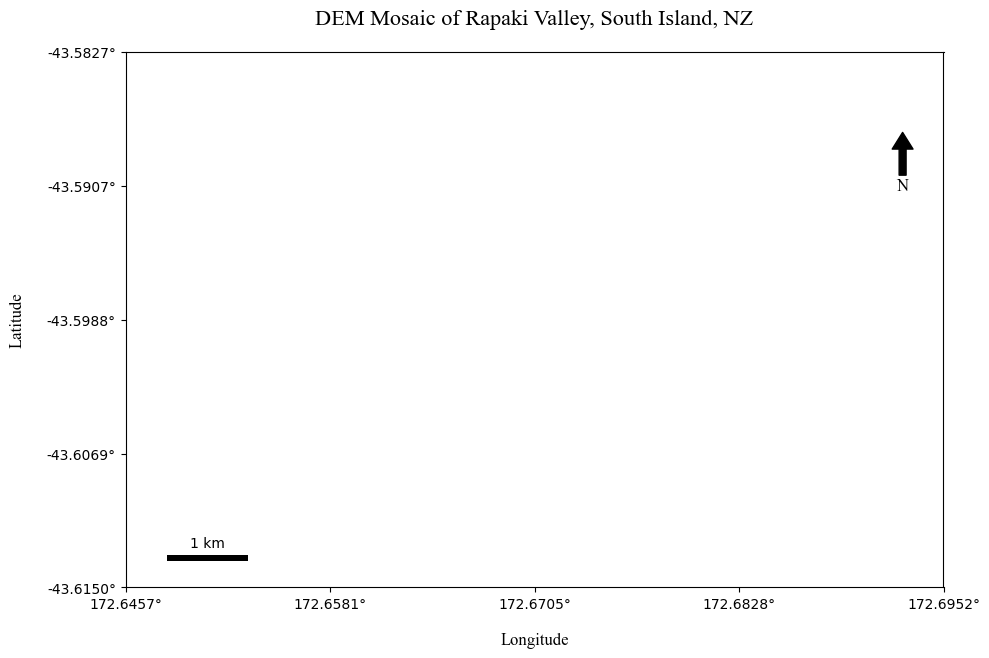

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
import rasterio
from rasterio.transform import xy
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import LightSource
from matplotlib import patches
from matplotlib import ticker
import matplotlib.font_manager as fm

# Step 1: Load your DEM file and reproject to EPSG:4326
with rasterio.open('/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL ANALYSIS/mosaic_dem.tif') as src:
    # Reproject to EPSG:4326 (WGS84)
    dst_crs = 'EPSG:4326'
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create a new array for the reprojected DEM
    dem_array = np.empty((height, width), dtype=np.float32)

    # Perform the reprojection
    reproject(
        source=rasterio.band(src, 1),
        destination=dem_array,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )

    # Handle NoData values by masking them
    if src.nodata is not None:
        dem_array = np.ma.masked_equal(dem_array, src.nodata)

# Step 2: Plot the DEM
fig, ax = plt.subplots(figsize=(10, 8))
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem_array, vert_exag=1, dx=1, dy=1)

# Plot DEM as hillshade
ax.imshow(hillshade, cmap="gray", alpha=0.7)
ax.set_title("DEM Mosaic of Rapaki Valley, South Island, NZ", fontsize=16, fontname="Times New Roman", pad=20)

# Step 3: Overlay geographic coordinates
rows, cols = dem_array.shape
left, top = xy(transform, 0, 0)  # Top-left corner
right, bottom = xy(transform, rows, cols)  # Bottom-right corner

# Set axis limits
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

# Define custom tick labels for longitude and latitude
num_ticks = 5
xticks = np.linspace(left, right, num_ticks)
yticks = np.linspace(bottom, top, num_ticks)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([f"{tick:.4f}°" for tick in xticks])
ax.set_yticklabels([f"{tick:.4f}°" for tick in yticks])

# Add labels
ax.set_xlabel("Longitude", fontsize=12, fontname="Times New Roman", labelpad=15)
ax.set_ylabel("Latitude", fontsize=12, fontname="Times New Roman", labelpad=15)

# Add north arrow
ax.annotate("N", xy=(0.95, 0.85), xycoords="axes fraction",
            xytext=(0.95, 0.75), arrowprops=dict(facecolor="black", width=5, headwidth=15),
            ha="center", va="center", fontsize=12, fontname="Times New Roman", color="black")

# Add a scale bar
scale_bar_x, scale_bar_y = 0.05, 0.05
scale_bar_width = 0.1
scale_bar = patches.Rectangle((scale_bar_x, scale_bar_y), scale_bar_width, 0.01,
                               transform=ax.transAxes, facecolor="black")
ax.add_patch(scale_bar)
ax.text(scale_bar_x + scale_bar_width / 2, scale_bar_y + 0.02, "1 km", transform=ax.transAxes,
        ha="center", va="bottom", fontsize=10, color="black")

# Layout and show
plt.tight_layout()
plt.show()


DEM Min: -0.800000011920929, DEM Max: 495.7272033691406
DEM Shape: (2945, 4499)
Transform: | 0.00, 0.00, 172.65|
| 0.00,-0.00,-43.58|
| 0.00, 0.00, 1.00|
Bounds: (172.64574011089547, -43.58265289801347), (172.6951894303468, -43.61502192352673)
Masked DEM values detected.


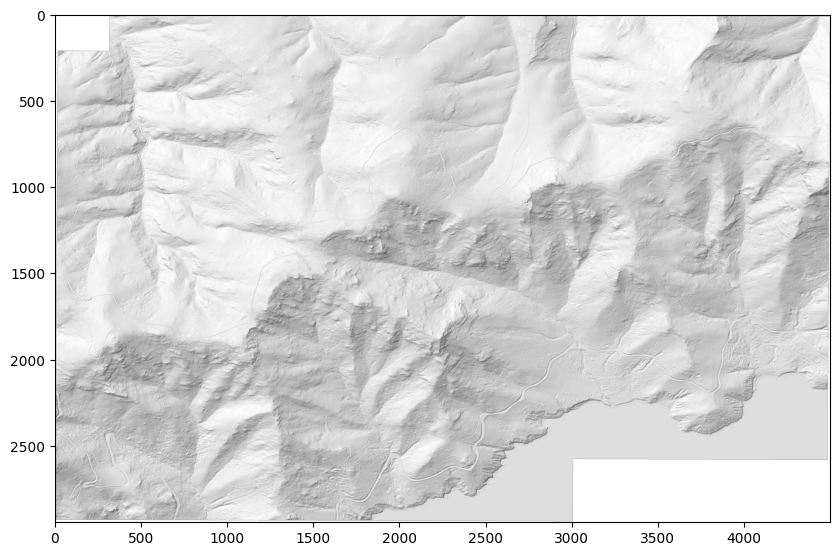

In [5]:
# Debugging: Ensure the DEM array contains valid data
print(f"DEM Min: {np.min(dem_array)}, DEM Max: {np.max(dem_array)}")
print(f"DEM Shape: {dem_array.shape}")

# Verify transform and bounds
print(f"Transform: {transform}")
rows, cols = dem_array.shape
print(f"Bounds: {xy(transform, 0, 0)}, {xy(transform, rows, cols)}")

# Plot the DEM with hillshade
fig, ax = plt.subplots(figsize=(10, 8))
ls = LightSource(azdeg=315, altdeg=45)

# Check for valid data and avoid masking the entire array
if np.ma.is_masked(dem_array):
    print("Masked DEM values detected.")
    if np.all(dem_array.mask):
        print("All DEM values are masked. Please verify data and bounds.")

hillshade = ls.hillshade(dem_array, vert_exag=1, dx=1, dy=1, fraction=1.0)

# Display DEM as hillshade
ax.imshow(hillshade, cmap="gray", alpha=0.7)


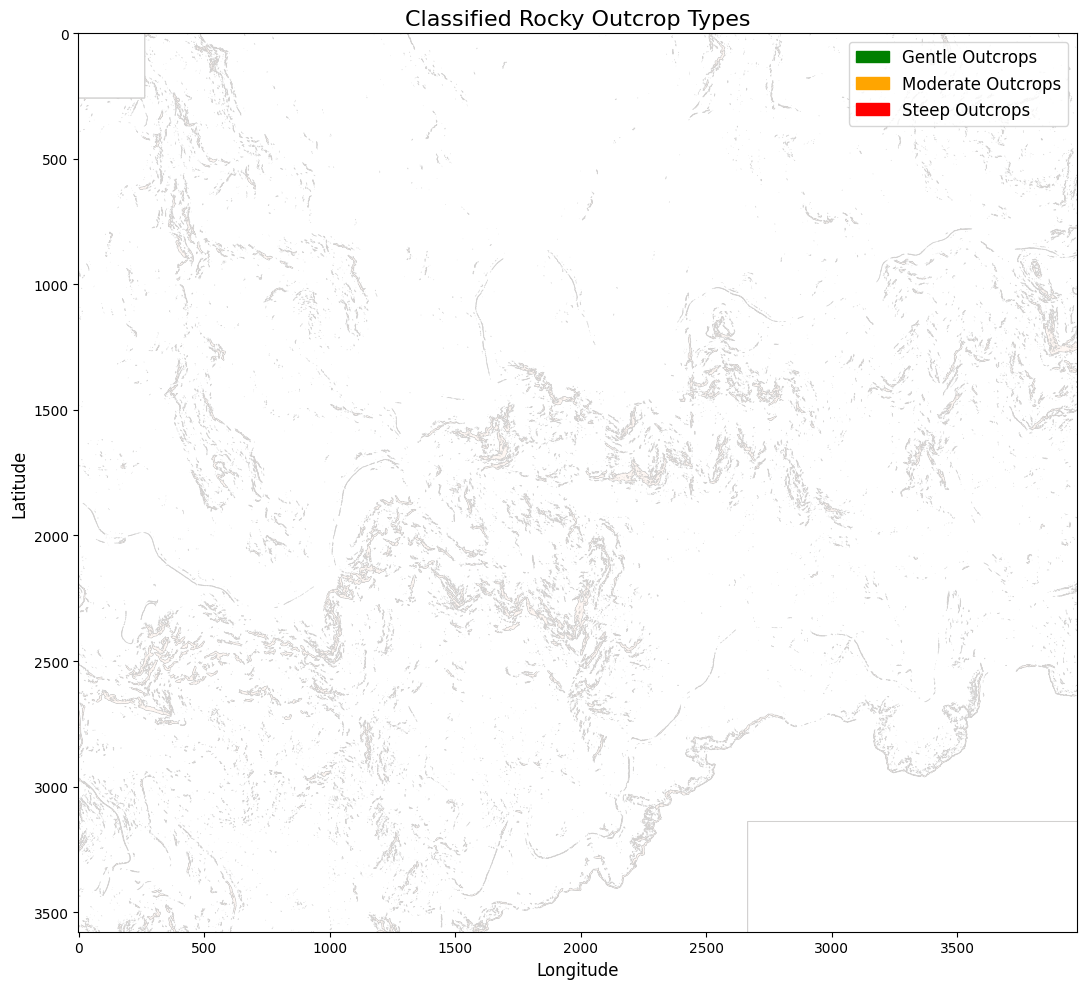

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import patches

# Load Sentinel-1 data (VV and VH polarization bands)
with rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vv-20250315t173950-20250315t174015-058318-07359a-001.tiff") as vv_src:
    vv_data = vv_src.read(1)
    vv_crs = vv_src.crs or "EPSG:4326"  # Assign default CRS if missing

with rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vh-20250315t173950-20250315t174015-058318-07359a-002.tiff") as vh_src:
    vh_data = vh_src.read(1)
    vh_crs = vh_src.crs or "EPSG:4326"

# Load DEM
dem_path = "/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL ANALYSIS/mosaic_dem.tif"
with rasterio.open(dem_path) as dem_src:
    dem_crs = dem_src.crs
    transform = dem_src.transform
    dem_array = dem_src.read(1)

# Function to reproject raster to match DEM
def reproject_raster(src_data, src_crs, dst_crs, shape, src_transform):
    reprojected_data = np.zeros(shape, dtype=np.float32)
    reproject(
        src_data, reprojected_data,
        src_crs=src_crs, dst_crs=dst_crs,
        src_transform=src_transform, dst_transform=src_transform,
        resampling=Resampling.nearest)
    return reprojected_data

# Reproject Sentinel-1 VV and VH data to match DEM
reprojected_vv = reproject_raster(vv_data, vv_crs, dem_crs, dem_array.shape, transform)
reprojected_vh = reproject_raster(vh_data, vh_crs, dem_crs, dem_array.shape, transform)

# Compute slope from DEM
gradient_x, gradient_y = np.gradient(dem_array, transform[0], transform[4])
slope_array = np.arctan(np.sqrt(gradient_x**2 + gradient_y**2)) * (180 / np.pi)  # Convert to degrees

# Define classification thresholds
slope_thresholds = {
    "gentle_slope": (5, 20),
    "moderate_slope": (20, 45),
    "steep_slope": (45, 90)
}
vv_thresholds = {
    "low_backscatter": (-20, -10),
    "moderate_backscatter": (-10, 0),
    "high_backscatter": (0, 10)
}

# Create masks for slope categories
gentle_mask = (slope_array >= 5) & (slope_array < 20)
moderate_mask = (slope_array >= 20) & (slope_array < 45)
steep_mask = (slope_array >= 45) & (slope_array <= 90)

# Create masks for VV backscatter categories
low_vv_mask = (reprojected_vv >= -20) & (reprojected_vv < -10)
moderate_vv_mask = (reprojected_vv >= -10) & (reprojected_vv < 0)
high_vv_mask = (reprojected_vv >= 0) & (reprojected_vv <= 10)

# Assume rocky_outcrops_mask is already defined
rocky_outcrops_mask = (slope_array >= 5)  # Example: using slope as proxy

# Classify outcrops by slope and backscatter
gentle_outcrops = gentle_mask & rocky_outcrops_mask & low_vv_mask
moderate_outcrops = moderate_mask & rocky_outcrops_mask & moderate_vv_mask
steep_outcrops = steep_mask & rocky_outcrops_mask & high_vv_mask

# Plot classified rocky outcrops
fig, ax = plt.subplots(figsize=(12, 10))

# Create hillshade effect
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem_array, vert_exag=1, dx=1, dy=1)
ax.imshow(hillshade, cmap="gray", alpha=0.7, extent=(
    dem_src.bounds[0], dem_src.bounds[2], dem_src.bounds[1], dem_src.bounds[3]
))

# Overlay classified outcrops
ax.imshow(np.ma.masked_where(~gentle_outcrops, gentle_outcrops), cmap="Greens", alpha=0.7)
ax.imshow(np.ma.masked_where(~moderate_outcrops, moderate_outcrops), cmap="Oranges", alpha=0.7)
ax.imshow(np.ma.masked_where(~steep_outcrops, steep_outcrops), cmap="Reds", alpha=0.7)

# Add legend
legend_patches = [
    patches.Patch(color="green", label="Gentle Outcrops"),
    patches.Patch(color="orange", label="Moderate Outcrops"),
    patches.Patch(color="red", label="Steep Outcrops")
]
ax.legend(handles=legend_patches, loc="upper right", fontsize=12)

# Add title and labels
ax.set_title("Classified Rocky Outcrop Types", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

plt.tight_layout()
plt.show()

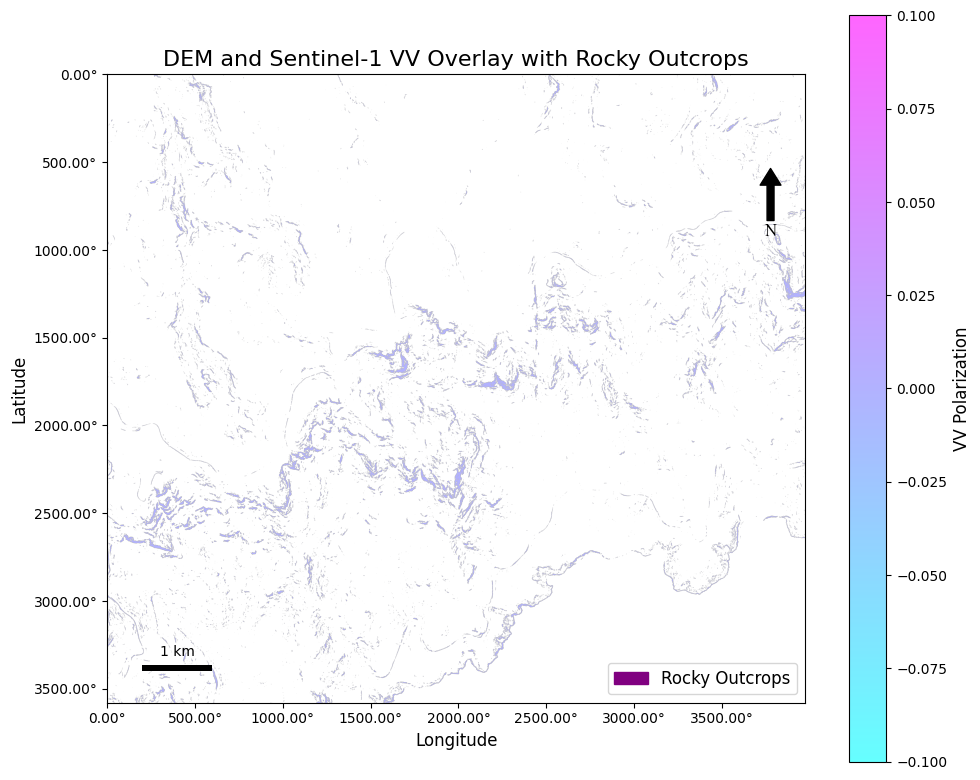

In [19]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import patches

# Load Sentinel-1 data (VV and VH polarization bands)
with rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vv-20250315t173950-20250315t174015-058318-07359a-001.tiff") as vv_src:
    vv_data = vv_src.read(1)  # Read the VV band
    vv_crs = vv_src.crs  # Get CRS of the VV data
    if vv_crs is None:  # If CRS is missing, assign a default CRS (e.g., EPSG:4326)
        vv_crs = "EPSG:4326"

with rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vh-20250315t173950-20250315t174015-058318-07359a-002.tiff") as vh_src:
    vh_data = vh_src.read(1)  # Read the VH band
    vh_crs = vh_src.crs  # Get CRS of the VH data
    if vh_crs is None:  # If CRS is missing, assign a default CRS (e.g., EPSG:4326)
        vh_crs = "EPSG:4326"

# Reproject Sentinel-1 data to match DEM CRS and shape if necessary
def reproject_raster(src_data, src_crs, dst_crs, shape, src_transform):
    """Reproject raster to match destination CRS and shape"""
    reprojected_data = np.zeros(shape, dtype=np.float32)
    reproject(
        src_data, reprojected_data,
        src_crs=src_crs, dst_crs=dst_crs,
        src_transform=src_transform, dst_transform=src_transform,
        resampling=Resampling.nearest)
    return reprojected_data

# Load DEM and reproject
with rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL ANALYSIS/mosaic_dem.tif") as dem_src:
    dem_crs = dem_src.crs  # Get DEM CRS
    transform = dem_src.transform  # Get DEM transform
    dem_array = dem_src.read(1)  # Load DEM array (assuming it's a single band)

# Reproject Sentinel-1 VV and VH data to match DEM's CRS and shape
reprojected_vv = reproject_raster(vv_data, vv_crs, dem_crs, dem_array.shape, transform)
reprojected_vh = reproject_raster(vh_data, vh_crs, dem_crs, dem_array.shape, transform)

# Mask for rocky outcrops (already done in your code)
rocky_outcrops_mask = rocky_outcrops  # Replace with your actual rocky outcrops mask

# Plotting the DEM with rocky outcrops and Sentinel-1 data overlay
fig, ax = plt.subplots(figsize=(10, 8))

# Create hillshade effect for DEM
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem_array, vert_exag=1, dx=1, dy=1)

# Display hillshade on top of the DEM
ax.imshow(hillshade, cmap="cividis", alpha=0.7, extent=(
    dem_src.bounds[0],  # xmin
    dem_src.bounds[2],  # xmax
    dem_src.bounds[1],  # ymin
    dem_src.bounds[3]   # ymax
))

# Mask rocky outcrops with the rocky_outcrops mask and overlay it on the DEM
rocky_overlay = np.ma.masked_where(~rocky_outcrops_mask, rocky_outcrops_mask)
ax.imshow(rocky_overlay, cmap="copper", alpha=1.0, extent=(
    dem_src.bounds[0],  # xmin
    dem_src.bounds[2],  # xmax
    dem_src.bounds[1],  # ymin
    dem_src.bounds[3]   # ymax
))

# Overlay VV and VH Sentinel-1 data over rocky outcrops
# Plot the VV band where the rocky outcrops are located
vv_overlay = np.ma.masked_where(~rocky_outcrops_mask, reprojected_vv)  # Mask VV data to rocky outcrops
ax.imshow(vv_overlay, cmap="cool", alpha=1.0, extent=(
    dem_src.bounds[0],  # xmin
    dem_src.bounds[2],  # xmax
    dem_src.bounds[1],  # ymin
    dem_src.bounds[3]   # ymax
))

# Add colorbar for Sentinel-1 VV data
vv_cbar = plt.colorbar(ax.imshow(vv_overlay, cmap="cool", alpha=0.6), ax=ax)
vv_cbar.set_label("VV Polarization", fontsize=12)

# Add title and labels
ax.set_title("DEM and Sentinel-1 VV Overlay with Rocky Outcrops", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add Legend for rocky outcrops
rocky_patch = patches.Patch(color="purple", label="Rocky Outcrops")
ax.legend(handles=[rocky_patch], loc="lower right", fontsize=12)

# Add a north arrow
arrow_length = 0.1 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 10% of map width
ax.annotate("N", xy=(0.95, 0.85), xycoords="axes fraction",
            xytext=(0.95, 0.75), arrowprops=dict(facecolor="black", width=5, headwidth=15),
            ha="center", va="center", fontsize=12, fontname="Times New Roman", color="black")

# Fine-tune tick labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}°"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.2f}°"))

# Scale bar
scale_bar_x, scale_bar_y = 0.05, 0.05  # Adjust these to fit your plot
scale_bar_width = 0.1
scale_bar = patches.Rectangle((scale_bar_x, scale_bar_y), scale_bar_width, 0.01,
                               transform=ax.transAxes, facecolor="black")
ax.add_patch(scale_bar)

# Label above the scale bar
scale_bar_label_x = scale_bar_x + scale_bar_width / 2  # Center the label horizontally
scale_bar_label_y = scale_bar_y + 0.02  # Position the label slightly above the scale bar
ax.text(scale_bar_label_x, scale_bar_label_y, "1 km", transform=ax.transAxes,
        ha="center", va="bottom", fontsize=10, color="black")


# Show the plot
plt.tight_layout()
plt.show()


VV CRS: EPSG:4326
VH CRS: EPSG:4326
DEM CRS: EPSG:2193
Reprojecting data: Source CRS=EPSG:4326, Destination CRS=EPSG:2193
Reprojecting data: Source CRS=EPSG:4326, Destination CRS=EPSG:2193


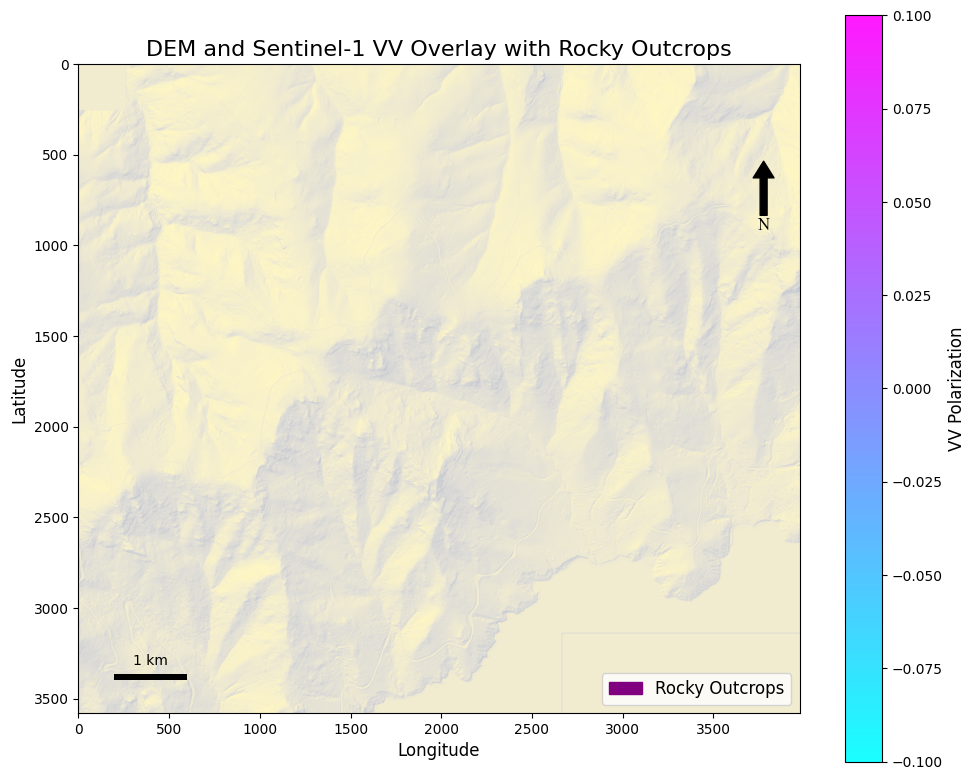

In [33]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import patches
import matplotlib.ticker as ticker

# Suppress warnings for divide by zero and invalid values
np.seterr(divide='ignore', invalid='ignore')

# Load Sentinel-1 data
def load_sentinel_band(filepath, default_crs="EPSG:4326"):
    with rasterio.open(filepath) as src:
        data = src.read(1)
        crs = src.crs or CRS.from_string(default_crs)  # Ensure CRS is defined
        transform = src.transform
    return data, crs, transform

# Load VV and VH bands
vv_data, vv_crs, vv_transform = load_sentinel_band("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vv-20250315t173950-20250315t174015-058318-07359a-001.tiff")
vh_data, vh_crs, vh_transform = load_sentinel_band("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vh-20250315t173950-20250315t174015-058318-07359a-002.tiff")

# Load DEM data
with rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL ANALYSIS/mosaic_dem.tif") as dem_src:
    dem_array = dem_src.read(1)
    dem_crs = dem_src.crs
    dem_transform = dem_src.transform

# Debug print to verify CRS
print(f"VV CRS: {vv_crs}")
print(f"VH CRS: {vh_crs}")
print(f"DEM CRS: {dem_crs}")

# Reproject raster data
def reproject_raster(src_data, src_crs, dst_crs, src_transform, dst_transform, shape):
    if not src_crs or not dst_crs:
        raise ValueError(f"Both source CRS ({src_crs}) and destination CRS ({dst_crs}) must be defined.")
    print(f"Reprojecting data: Source CRS={src_crs}, Destination CRS={dst_crs}")
    reprojected_data = np.zeros(shape, dtype=np.float32)
    reproject(
        src_data, reprojected_data,
        src_transform=src_transform, dst_transform=dst_transform,
        src_crs=src_crs, dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return reprojected_data

# Reproject VV and VH data to match DEM
reprojected_vv = reproject_raster(vv_data, vv_crs, dem_crs, vv_transform, dem_transform, dem_array.shape)
reprojected_vh = reproject_raster(vh_data, vh_crs, dem_crs, vh_transform, dem_transform, dem_array.shape)

# Calculate CPR and DLP
epsilon = 1e-6  # To avoid division by zero
sum_vv_vh = reprojected_vv + reprojected_vh + epsilon
cpr_data = (reprojected_vv - reprojected_vh) / sum_vv_vh
dlp_data = np.abs(reprojected_vv - reprojected_vh) / sum_vv_vh

# Generate rocky outcrop masks
rocky_outcrops_mask = np.zeros_like(cpr_data, dtype=np.uint8)
rocky_outcrops_mask[(cpr_data >= 0.34) & (cpr_data <= 0.73) & (dlp_data >= 0.18) & (dlp_data <= 0.20)] = 1
rocky_outcrops_mask[(cpr_data >= 0.69) & (cpr_data <= 1.14) & (dlp_data >= 0.19) & (dlp_data <= 0.20)] = 2

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem_array, vert_exag=1, dx=1, dy=1)
ax.imshow(hillshade, cmap="cividis", alpha=0.3)

# Overlay rocky outcrops
rocky_overlay = np.ma.masked_where(~rocky_outcrops_mask.astype(bool), rocky_outcrops_mask)
ax.imshow(rocky_overlay, cmap="magma", alpha=1.0)

# Overlay VV polarization data
vv_overlay = np.ma.masked_where(~rocky_outcrops_mask.astype(bool), reprojected_vv)
vv_img = ax.imshow(vv_overlay, cmap="cool", alpha=0.9)
cbar = plt.colorbar(vv_img, ax=ax)
cbar.set_label("VV Polarization", fontsize=12)

# Title and labels
ax.set_title("DEM and Sentinel-1 VV Overlay with Rocky Outcrops", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Rocky outcrops legend
rocky_patch = patches.Patch(color="purple", label="Rocky Outcrops")
ax.legend(handles=[rocky_patch], loc="lower right", fontsize=12)

# Scale bar
scale_bar_x, scale_bar_y = 0.05, 0.05  # Adjust these to fit your plot
scale_bar_width = 0.1
scale_bar = patches.Rectangle((scale_bar_x, scale_bar_y), scale_bar_width, 0.01,
                               transform=ax.transAxes, facecolor="black")
ax.add_patch(scale_bar)

# Label for scale bar
scale_bar_label_x = scale_bar_x + scale_bar_width / 2  # Center the label horizontally
scale_bar_label_y = scale_bar_y + 0.02  # Position the label slightly above the scale bar
ax.text(scale_bar_label_x, scale_bar_label_y, "1 km", transform=ax.transAxes,
        ha="center", va="bottom", fontsize=10, color="black")

# North arrow
ax.annotate("N", xy=(0.95, 0.85), xycoords="axes fraction",
            xytext=(0.95, 0.75), arrowprops=dict(facecolor="black", width=5, headwidth=15),
            ha="center", va="center", fontsize=12, fontname="Times New Roman", color="black")

plt.tight_layout()
plt.show()


In [36]:
import matplotlib.pyplot as plt
vv_array = rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vv-20250315t173950-20250315t174015-058318-07359a-001.tiff").read(1)
vh_array = rasterio.open("/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/SENTINEL DATA/S1A_IW_GRDH_1SDV_20250315T173950_20250315T174015_058318_07359A_1608.SAFE/measurement/s1a-iw-grd-vh-20250315t173950-20250315t174015-058318-07359a-002.tiff").read(1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("VV Data")
plt.imshow(vv_array, cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("VH Data")
plt.imshow(vh_array, cmap="gray")
plt.colorbar()
plt.show()


: 

In [3]:
import numpy as np
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# File paths
input_dem_path = "/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/Rapaki Misc Data/mosaic_dem.tif"
output_shapefile_path = "/Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/Rapaki Misc Data/rocky_outcrops.shp"

# Step 1: Load DEM file
with rasterio.open(input_dem_path) as src:
    dem_array = src.read(1)  # First band
    transform = src.transform
    crs = src.crs

    # Handle NoData values
    if src.nodata is not None:
        dem_array = np.ma.masked_equal(dem_array, src.nodata)

# Step 2: Compute slope using Sobel filters
from scipy.ndimage import sobel
gradient_x = sobel(dem_array, axis=0)
gradient_y = sobel(dem_array, axis=1)
slope = np.hypot(gradient_x, gradient_y)

# Step 3: Create a mask for rocky outcrops
rocky_outcrop_lower_threshold = 8.0  # Adjust based on your needs
rocky_outcrop_upper_threshold = 90.0  # Adjust based on your needs
rocky_outcrops = (slope >= rocky_outcrop_lower_threshold) & (slope <= rocky_outcrop_upper_threshold)

# Step 4: Convert mask to vector features
rocky_shapes = shapes(rocky_outcrops.astype(np.uint8), transform=transform)
rocky_geometries = [shape(geom) for geom, value in rocky_shapes if value == 1]

# Step 5: Create a GeoDataFrame
rocky_gdf = gpd.GeoDataFrame({"geometry": rocky_geometries}, crs=crs)

# Step 6: Save to Shapefile
rocky_gdf.to_file(output_shapefile_path, driver="ESRI Shapefile")

print(f"Rocky outcrop layer saved to {output_shapefile_path}")


Rocky outcrop layer saved to /Users/tomassalazar/Desktop/WUSTL/School/Research Geology UC- FA /RV HYP MAP/Rapaki Misc Data/rocky_outcrops.shp
